In [20]:
import seaborn as sns
from typing import Union
from sklearn.decomposition import non_negative_factorization
import numpy as np
import scanpy as sc
from pathlib import Path
from tqdm import tqdm
import functools
import pickle

In [101]:
def cosine_similarity_rows(A, B):
    norms_A = np.linalg.norm(A, axis=1)
    norms_B = np.linalg.norm(B, axis=1)
    dot_products = np.einsum('ij,ij->i', A, B)
    return dot_products / (norms_A * norms_B)

def create_folders(base_path: str, structure: dict, current_path: Union[str, Path] = None) -> None:
    if current_path is None:
        current_path = Path(base_path)
    Path(current_path).mkdir(exist_ok=True)
    for key, value in structure.items():
        new_path = current_path / str(key)
        if isinstance(value, dict):
            Path(new_path).mkdir(exist_ok=True)
            create_folders(base_path, value, new_path)

In [98]:
def cosine_similarity_rows(A, B):
    norms_A = np.linalg.norm(A, axis=0)
    norms_B = np.linalg.norm(B, axis=0)
    dot_products = np.einsum('ij,ij->i', A, B)
    return dot_products / (norms_A * norms_B)

In [22]:
create_folders(
    str(Path.cwd()),
    {
        "data": {
            "inputQuery": {},
            "inputRef": {},
            "nico_out": {},
        }
    }
)

In [33]:
n_components_range

[4, 8, 16, 32, 64, 128, 256]

In [23]:
adata_sp = sc.read_h5ad(Path.cwd() / "data" / "nico_out" / "nico_celltype_annotation.h5ad")
adata_sc = sc.read_h5ad(Path.cwd() / "data" / "inputRef" / "input_ref.h5ad")
sc.pp.filter_genes(adata_sp, min_counts=3)
#sc.pp.log1p(adata_sp)
#sc.pp.normalize_total(adata_sp, target_sum=1e6)

sc.pp.filter_genes(adata_sc, min_counts=3)
#sc.pp.log1p(adata_sc)
#sc.pp.normalize_total(adata_sc, target_sum=1e6)

In [24]:
shared_genes_mask = np.isin(adata_sc.var_names, adata_sp.var_names)
shared_genes = list(adata_sc[:, shared_genes_mask].var_names)
#spatial counts matrix
X_sp = adata_sp[:, shared_genes].X.toarray().copy()
#single cell counts matrix
X_sc = adata_sc.X.toarray().copy()

In [147]:

n_components_range = [2 ** x for x in range(2, 9)]

/var/folders/qm/v_v5_1r52bx792m7x2mh177c0000gn/T/ipykernel_46328/672243977.py:26: UserWarning: 
The palette list has fewer values (1) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot(
/var/folders/qm/v_v5_1r52bx792m7x2mh177c0000gn/T/ipykernel_46328/672243977.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


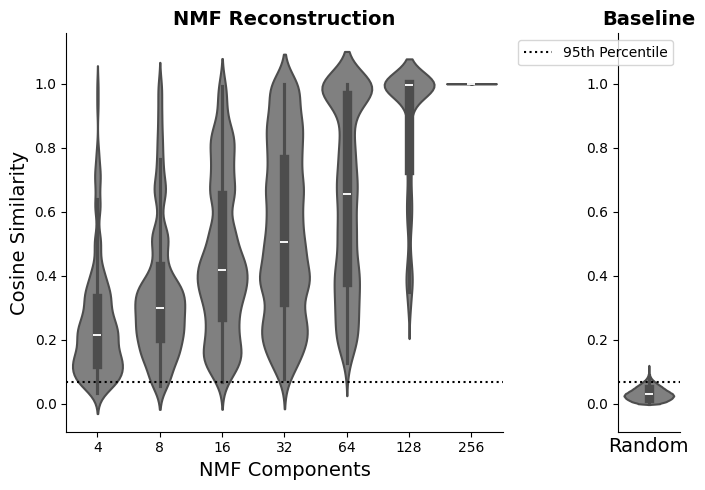

In [181]:

violin_data_1 = [
    cosine_similarity_rows(
        X_sp.T,
        (lambda x: x[0] @ x[1])(
            non_negative_factorization(X_sp, n_components=n_components)
        ).T,
    )
    for n_components in n_components_range
]

violin_data_2 = functools.reduce(
    lambda a, b: np.hstack([a, b]),
    [cosine_similarity_rows(X_sp.T, np.random.choice(X_sp.flatten(), X_sp.shape).T) for _ in range(1000)]
)

percentile_95 = np.percentile(violin_data_2, 95)
fig = plt.figure(figsize=(7, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[7, 1]) 

ax1 = fig.add_subplot(gs[0])
sns.violinplot(
    data=violin_data_1,
    ax=ax1,
    bw_adjust=0.5,
    linewidth=1.5,
    palette=["gray"],
)
ax1.set_xticks(range(len(n_components_range)))
ax1.set_xticklabels(n_components_range)
ax1.set_xlabel("NMF Components", fontsize=14, color="black")
ax1.set_ylabel("Cosine Similarity", fontsize=14, color="black")
ax1.set_title("NMF Reconstruction", fontsize=14, fontweight="bold", color="black")
ax1.axhline(y=percentile_95, color="black", linestyle="dotted", linewidth=1.5, label="95th Percentile")

ax2 = fig.add_subplot(gs[1], sharey=ax1) 
sns.violinplot(
    data=violin_data_2,
    ax=ax2,
    bw_adjust=0.5,
    linewidth=1.5,
    palette=["gray"],
)
ax2.axhline(y=percentile_95, color="black", linestyle="dotted", linewidth=1.5, label="95th Percentile")
ax2.set_xticks([])
ax2.set_xlabel("Random", fontsize=14, color="black")
ax2.set_title("Baseline", fontsize=14, fontweight="bold", color="black")
ax2.legend()
sns.despine()
plt.tight_layout()


plt.savefig("cosine_similarity_violinplots_side_by_side.svg", dpi=300, bbox_inches="tight")
plt.show()

 29%|██▊       | 2/7 [00:07<00:17,  3.58s/it]/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
 43%|████▎     | 3/7 [00:12<00:17,  4.33s/it]/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
 57%|█████▋    | 4/7 [00:19<00:15,  5.29s/it]/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
 71%|███████▏  | 5/7 [00:34<00:17,  8.93s/it]/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.

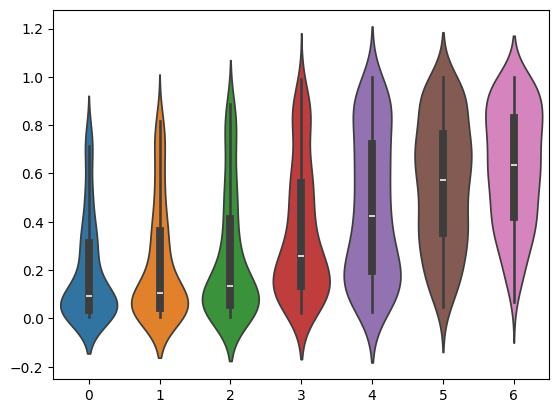

In [120]:
test = {n_components: (non_negative_factorization(X_sc, n_components=n_components)) for n_components in tqdm(n_components_range)}
sns.violinplot([cosine_similarity_rows(X_sc[:, shared_genes_mask].T, (nmf_res[0] @ nmf_res[1][:, shared_genes_mask]).T) for nmf_res in test.values()])

with open(f"nmf_test_results_{n_components_range}.pkl", "wb") as f:
    pickle.dump(test, f)

/var/folders/qm/v_v5_1r52bx792m7x2mh177c0000gn/T/ipykernel_46328/2181034123.py:13: UserWarning: 
The palette list has fewer values (1) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot(
/var/folders/qm/v_v5_1r52bx792m7x2mh177c0000gn/T/ipykernel_46328/2181034123.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


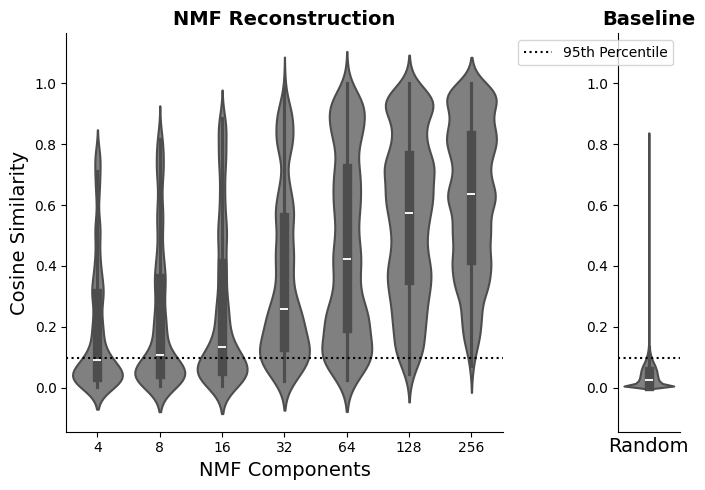

In [190]:
violin_data_1 = [cosine_similarity_rows(X_sc[:, shared_genes_mask].T, (nmf_res[0] @ nmf_res[1][:, shared_genes_mask]).T) for nmf_res in test.values()]

violin_data_2 = functools.reduce(
    lambda a, b: np.hstack([a, b]),
    [cosine_similarity_rows(X_sc.T, np.random.choice(X_sc.flatten(), X_sc.shape).T) for _ in range(16)]
)

percentile_95 = np.percentile(violin_data_2, 95)
fig = plt.figure(figsize=(7, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[7, 1]) 

ax1 = fig.add_subplot(gs[0])
sns.violinplot(
    data=violin_data_1,
    ax=ax1,
    bw_adjust=0.5,
    linewidth=1.5,
    palette=["gray"],
)
ax1.set_xticks(range(len(n_components_range)))
ax1.set_xticklabels(n_components_range)
ax1.set_xlabel("NMF Components", fontsize=14, color="black")
ax1.set_ylabel("Cosine Similarity", fontsize=14, color="black")
ax1.set_title("NMF Reconstruction", fontsize=14, fontweight="bold", color="black")
ax1.axhline(y=percentile_95, color="black", linestyle="dotted", linewidth=1.5, label="95th Percentile")

ax2 = fig.add_subplot(gs[1], sharey=ax1) 
sns.violinplot(
    data=violin_data_2,
    ax=ax2,
    bw_adjust=0.5,
    linewidth=1.5,
    palette=["gray"],
)
ax2.axhline(y=percentile_95, color="black", linestyle="dotted", linewidth=1.5, label="95th Percentile")
ax2.set_xticks([])
ax2.set_xlabel("Random", fontsize=14, color="black")
ax2.set_title("Baseline", fontsize=14, fontweight="bold", color="black")
ax2.legend()
sns.despine()
plt.tight_layout()

plt.savefig("cosine_similarity_violinplots_side_by_side.svg", dpi=300, bbox_inches="tight")
plt.show()

  0%|          | 0/7 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
 29%|██▊       | 2/7 [00:00<00:00, 15.58it/s]/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
 57%|█████▋    | 4/7 [00:01<00:00,  3.41it/s]/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterat

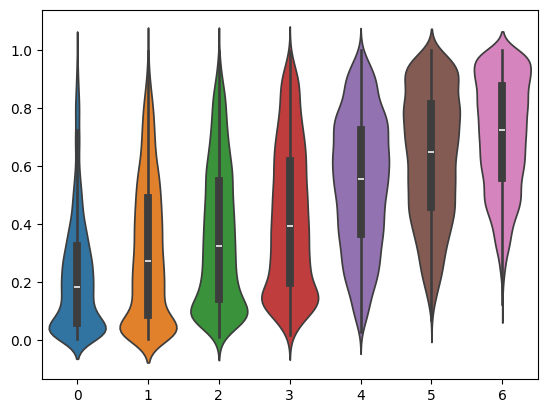

In [27]:
test2 = {n_components: non_negative_factorization(X_sp, H=nmf_res[1][:, shared_genes_mask], update_H=False, init="custom") for n_components, nmf_res in tqdm(test.items())}
sns.violinplot([cosine_similarity_rows(X_sp, x[0] @ x[1]) for x in test2.values()])

with open(f"nmf_test2_results_{n_components_range}.pkl", "wb") as f:
    pickle.dump(test2, f)

<Axes: >

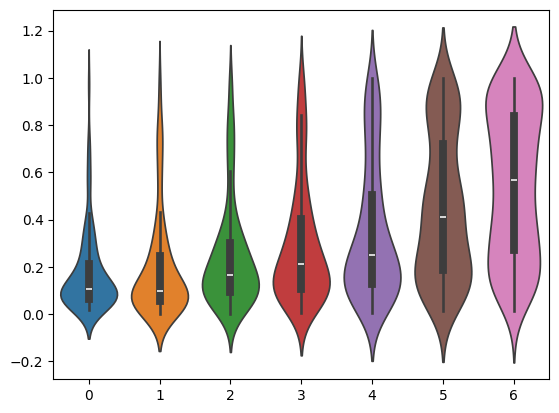

In [192]:
sns.violinplot([cosine_similarity_rows(X_sp.T, (x[0] @ x[1]).T) for x in test2.values()])

/var/folders/qm/v_v5_1r52bx792m7x2mh177c0000gn/T/ipykernel_46328/2185827202.py:13: UserWarning: 
The palette list has fewer values (1) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot(
/var/folders/qm/v_v5_1r52bx792m7x2mh177c0000gn/T/ipykernel_46328/2185827202.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


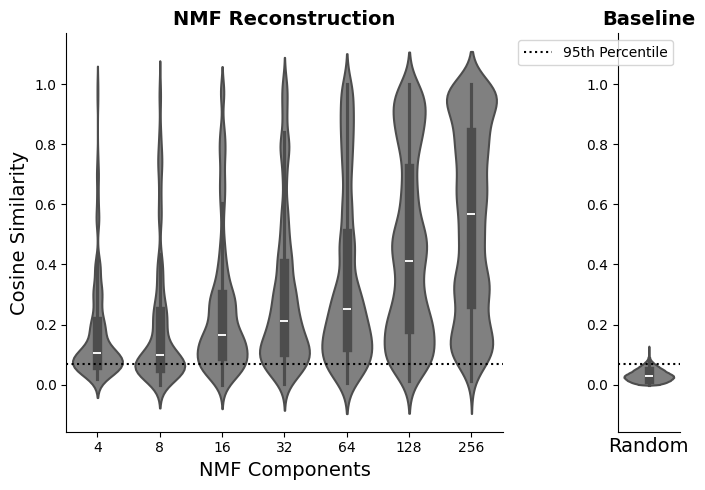

In [191]:
violin_data_1 = [cosine_similarity_rows(X_sp.T, (x[0] @ x[1]).T) for x in test2.values()]

violin_data_2 = functools.reduce(
    lambda a, b: np.hstack([a, b]),
    [cosine_similarity_rows(X_sp.T, np.random.choice(X_sp.flatten(), X_sp.shape).T) for _ in range(1000)]
)

percentile_95 = np.percentile(violin_data_2, 95)
fig = plt.figure(figsize=(7, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[7, 1]) 

ax1 = fig.add_subplot(gs[0])
sns.violinplot(
    data=violin_data_1,
    ax=ax1,
    bw_adjust=0.5,
    linewidth=1.5,
    palette=["gray"],
)
ax1.set_xticks(range(len(n_components_range)))
ax1.set_xticklabels(n_components_range)
ax1.set_xlabel("NMF Components", fontsize=14, color="black")
ax1.set_ylabel("Cosine Similarity", fontsize=14, color="black")
ax1.set_title("NMF Reconstruction", fontsize=14, fontweight="bold", color="black")
ax1.axhline(y=percentile_95, color="black", linestyle="dotted", linewidth=1.5, label="95th Percentile")

ax2 = fig.add_subplot(gs[1], sharey=ax1) 
sns.violinplot(
    data=violin_data_2,
    ax=ax2,
    bw_adjust=0.5,
    linewidth=1.5,
    palette=["gray"],
)
ax2.axhline(y=percentile_95, color="black", linestyle="dotted", linewidth=1.5, label="95th Percentile")
ax2.set_xticks([])
ax2.set_xlabel("Random", fontsize=14, color="black")
ax2.set_title("Baseline", fontsize=14, fontweight="bold", color="black")
ax2.legend()
sns.despine()
plt.tight_layout()

plt.savefig("cosine_similarity_violinplots_side_by_side.svg", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
test3 = {n_components: functools.reduce(lambda a, b: np.hstack([a, b]), [(lambda x: x[0] @ nmf_res[1][:, shared_genes_mask])(non_negative_factorization(X_sp[:, ~np.isin(shared_genes, gene)], H=nmf_res[1][:, shared_genes_mask][:, ~np.isin(shared_genes, gene)], update_H=False, init="custom"))[:, np.isin(shared_genes, gene)] for gene in shared_genes]) for n_components, nmf_res in tqdm(test.items())}

with open(f"nmf_test3_results_{n_components_range}.pkl", "wb") as f:
    pickle.dump(test3, f)

<Axes: >

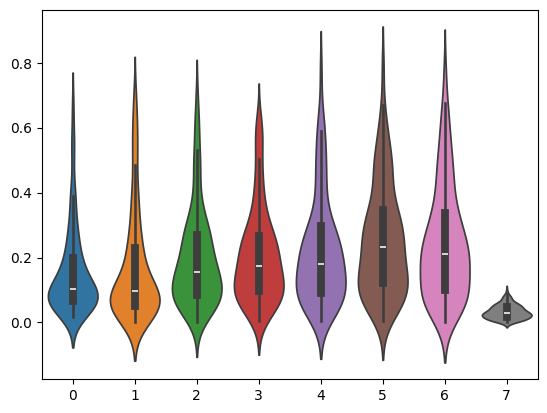

In [193]:
sns.violinplot([cosine_similarity_rows(X_sp.T, x_r.T) for x_r in test3.values()] + [cosine_similarity_rows(X_sp.T, np.random.choice(X_sp.flatten(), X_sp.T.shape))])

/var/folders/qm/v_v5_1r52bx792m7x2mh177c0000gn/T/ipykernel_46328/3080043005.py:13: UserWarning: 
The palette list has fewer values (1) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot(
/var/folders/qm/v_v5_1r52bx792m7x2mh177c0000gn/T/ipykernel_46328/3080043005.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


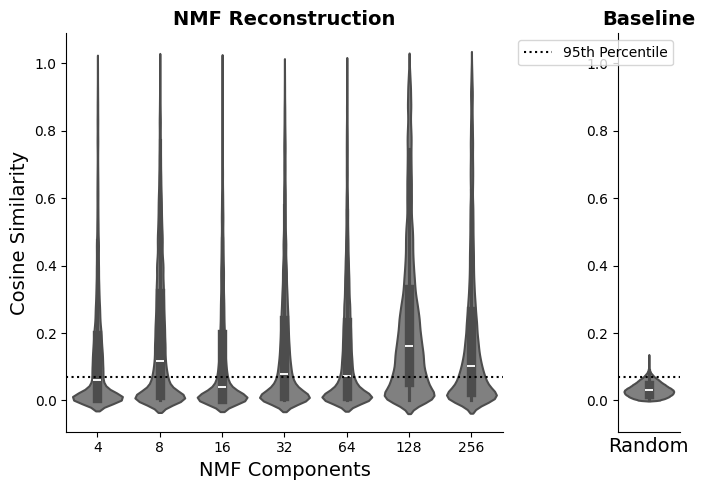

In [197]:
violin_data_1 = [cosine_similarity_rows(X_sp, x_r) for x_r in test3.values()]

violin_data_2 = functools.reduce(
    lambda a, b: np.hstack([a, b]),
    [cosine_similarity_rows(X_sp.T, np.random.choice(X_sp.flatten(), X_sp.shape).T) for _ in range(1000)]
)

percentile_95 = np.percentile(violin_data_2, 95)
fig = plt.figure(figsize=(7, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[7, 1]) 

ax1 = fig.add_subplot(gs[0])
sns.violinplot(
    data=violin_data_1,
    ax=ax1,
    bw_adjust=0.5,
    linewidth=1.5,
    palette=["gray"],
)
ax1.set_xticks(range(len(n_components_range)))
ax1.set_xticklabels(n_components_range)
ax1.set_xlabel("NMF Components", fontsize=14, color="black")
ax1.set_ylabel("Cosine Similarity", fontsize=14, color="black")
ax1.set_title("NMF Reconstruction", fontsize=14, fontweight="bold", color="black")
ax1.axhline(y=percentile_95, color="black", linestyle="dotted", linewidth=1.5, label="95th Percentile")

ax2 = fig.add_subplot(gs[1], sharey=ax1) 
sns.violinplot(
    data=violin_data_2,
    ax=ax2,
    bw_adjust=0.5,
    linewidth=1.5,
    palette=["gray"],
)
ax2.axhline(y=percentile_95, color="black", linestyle="dotted", linewidth=1.5, label="95th Percentile")
ax2.set_xticks([])
ax2.set_xlabel("Random", fontsize=14, color="black")
ax2.set_title("Baseline", fontsize=14, fontweight="bold", color="black")
ax2.legend()
sns.despine()
plt.tight_layout()

plt.savefig("cosine_similarity_violinplots_side_by_side.svg", dpi=300, bbox_inches="tight")
plt.show()

In [196]:
adata_sp

AnnData object with n_obs × n_vars = 7416 × 203
    obs: 'umi_sct', 'log_umi_sct', 'gene_sct', 'log_gene_sct', 'umi_per_gene_sct', 'log_umi_per_gene_sct', 'leiden0.4', 'leiden0.5', 'nico_ct'
    var: 'Intercept_sct', 'log_umi_sct', 'theta_sct', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'genes_step1_sct', 'log10_gmean_sct', 'n_counts'
    uns: 'leiden', 'leiden0.5_colors', 'neighbors', 'pca', 'umap', 'nico_ct_colors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'